In [327]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils import data
import ipywidgets
import matplotlib.pyplot as plt
import random

device = torch.device('cpu')

In [314]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [315]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 4070 Ti SUPER'

In [316]:
def accuracy(y_hat, y):
    
    if len(y_hat) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [317]:
trans = transforms.ToTensor()

In [318]:
mnist_train = torchvision.datasets.FashionMNIST(
root="./data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
root="./data", train=False, transform=trans, download=True)

In [319]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    net.eval()
    if not device:
        device = next(iter(net.parameters())).device
    metrics = Accumulator(2)
    for X,y in data_iter:
        if isinstance(X, list):
            X = [i.to(device) for i in metrics]
        else:
            X = X.to(device)
        y = y.to(device)
        metrics.add(accuracy(net(X),y),y.numel())
        return metrics[0] / metrics[1]

In [320]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [321]:
train_iter = data.DataLoader(mnist_train,256,True)
test_iter = data.DataLoader(mnist_test,256,True)

In [322]:
net = nn.Sequential(
    nn.Conv2d(1,6,5,padding=2),
    nn.Sigmoid(),
    nn.AvgPool2d(2,2),
    nn.Conv2d(6,16,5),
    nn.Sigmoid(),
    nn.AvgPool2d(2,2),
    nn.Flatten(),
    nn.Linear(400,120),
    nn.Sigmoid(),
    nn.Linear(120,84),
    nn.Sigmoid(),
    nn.Linear(84,10)
)

net = net.to(device)

loss = nn.CrossEntropyLoss()

updater = torch.optim.SGD(net.parameters(),lr=0.9)


In [323]:
num_epoch = 10

In [324]:
progress = ipywidgets.IntProgress(min=0,max=num_epoch-1)
progress.value=0
display(progress)

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

train_metrics = []

for epoch in range(num_epoch):
    net.train()
    metric = Accumulator(3)
    for X,y in train_iter:
        X = X.to(device)
        y = y.to(device)

        out = net(X)
        net.zero_grad()
        l = loss(out, y)
        l.backward()
        updater.step()
        with torch.no_grad():
            metric.add(l * X.shape[0], accuracy(out, y), X.shape[0])
    train_l = metric[0] / metric[2]
    train_acc = metric[1] / metric[2]

    test_acc = evaluate_accuracy_gpu(net, test_iter)

    print(f"Epoch: {epoch}, train_loss: {train_l}, train_accuracy: {train_acc}, test_accuracy: {test_acc}")
    train_metrics.append((epoch,train_l,train_acc,test_acc))
    progress.value = epoch

for item in train_metrics[-3:]:
    print(f"Epoch: {item[0]}, train_loss: {item[1]}, train_accuracy: {item[2]}, test_accuracy: {item[3]}")

IntProgress(value=0, max=9)

Epoch: 0, train_loss: 2.2984599922180178, train_accuracy: 0.1148, test_accuracy: 0.28125
Epoch: 1, train_loss: 1.1554452856699626, train_accuracy: 0.5321333333333333, test_accuracy: 0.56640625
Epoch: 2, train_loss: 0.8310576709747315, train_accuracy: 0.6754166666666667, test_accuracy: 0.6640625
Epoch: 3, train_loss: 0.7069139578501383, train_accuracy: 0.7203, test_accuracy: 0.71484375
Epoch: 4, train_loss: 0.6435663416544596, train_accuracy: 0.747, test_accuracy: 0.73828125
Epoch: 5, train_loss: 0.5952117958068848, train_accuracy: 0.7697333333333334, test_accuracy: 0.765625
Epoch: 6, train_loss: 0.5531619689941406, train_accuracy: 0.78615, test_accuracy: 0.765625
Epoch: 7, train_loss: 0.518610040918986, train_accuracy: 0.8027, test_accuracy: 0.75
Epoch: 8, train_loss: 0.4924743413925171, train_accuracy: 0.8127333333333333, test_accuracy: 0.78125
Epoch: 9, train_loss: 0.4709359110514323, train_accuracy: 0.8225, test_accuracy: 0.80078125
Epoch: 7, train_loss: 0.518610040918986, train_acc

(0.0, 2.5)

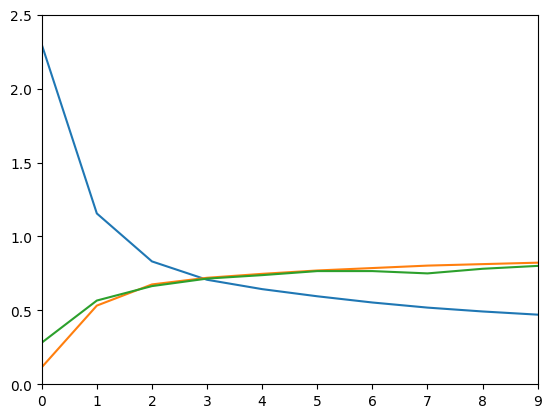

In [374]:
fig, ax = plt.subplots()
ax.plot(range(len(train_metrics)),[i[1] for i in train_metrics])
ax.plot(range(len(train_metrics)),[i[2] for i in train_metrics])
ax.plot(range(len(train_metrics)),[i[3] for i in train_metrics])
ax.set_xlim(0,len(train_metrics)-1)
ax.set_ylim(0,2.5)


Text(0.5, 1.0, 'Real Group: 9, Calculated Group: 9')

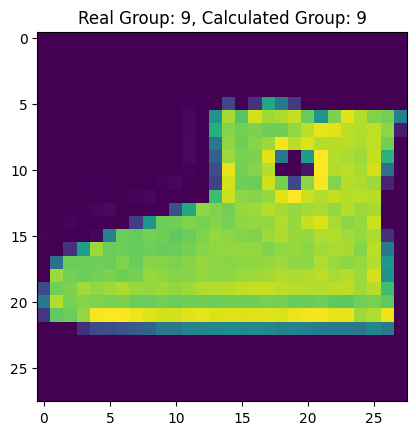

In [408]:
test_item = random.choice(mnist_test)
result = net(test_item[0].reshape(1,1,28,28))
fig, ax = plt.subplots()
ax.imshow(test_item[0].reshape((28,28)))
ax.set_title(f"Real Group: {test_item[1]}, Calculated Group: {result.argmax()}")